範例1： 練習爬取台幣對其他貨幣匯率資料

In [55]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt 

進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [56]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = 'https://rate.bot.com.tw/xrt?Lang=zh-TW'
resp = requests.get(url)
resp.encoding = 'utf-8'

html = BeautifulSoup(resp.text, 'lxml')
rate_table = html.find(name='table', attrs={'title': '牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class': 'visible-phone print_hide'})
print(currency.get_text().replace(' ', ''))

def print_currency(rate_row):
    buy_rate = rate_row.find(name='td', attrs={'data-table': '本行現金買入'})
    sell_rate = rate_row.find(name='td', attrs={'data-table': '本行現金賣出'})
    print(f'即時現金買入: {buy_rate.get_text()}，即時現金賣出: {sell_rate.get_text()}')

print_currency(rate_table[0])


美金(USD)

即時現金買入: 29.79，即時現金賣出: 30.46


作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [57]:
for rate in rate_table:
    print(rate.find(name='div', attrs={'class': 'visible-phone print_hide'}).text.replace(' ', ''))
    print_currency(rate)


美金(USD)

即時現金買入: 29.79，即時現金賣出: 30.46

港幣(HKD)

即時現金買入: 3.729，即時現金賣出: 3.933

英鎊(GBP)

即時現金買入: 38.43，即時現金賣出: 40.55

澳幣(AUD)

即時現金買入: 19.87，即時現金賣出: 20.65

加拿大幣(CAD)

即時現金買入: 22.35，即時現金賣出: 23.26

新加坡幣(SGD)

即時現金買入: 21.58，即時現金賣出: 22.49

瑞士法郎(CHF)

即時現金買入: 30.29，即時現金賣出: 31.49

日圓(JPY)

即時現金買入: 0.2676，即時現金賣出: 0.2804

南非幣(ZAR)

即時現金買入: -，即時現金賣出: -

瑞典幣(SEK)

即時現金買入: 2.74，即時現金賣出: 3.26

紐元(NZD)

即時現金買入: 19.08，即時現金賣出: 19.93

泰幣(THB)

即時現金買入: 0.846，即時現金賣出: 1.034

菲國比索(PHP)

即時現金買入: 0.5205，即時現金賣出: 0.6535

印尼幣(IDR)

即時現金買入: 0.00188，即時現金賣出: 0.00258

歐元(EUR)

即時現金買入: 32.47，即時現金賣出: 33.81

韓元(KRW)

即時現金買入: 0.0236，即時現金賣出: 0.0275

越南盾(VND)

即時現金買入: 0.00093，即時現金賣出: 0.00143

馬來幣(MYR)

即時現金買入: 6.265，即時現金賣出: 7.909

人民幣(CNY)

即時現金買入: 4.227，即時現金賣出: 4.389


範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

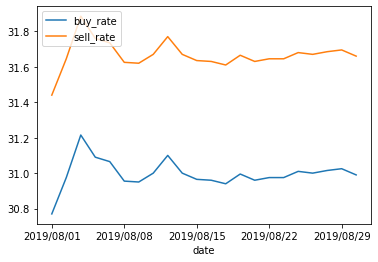

In [58]:
# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table': '歷史匯率'})
history_rate_link = 'https://rate.bot.com.tw' + history_link.a['href']
print(rate_table[0].find(name='div', attrs={'class': 'visible-phone print_hide'}).text.replace(' ', ''))
get_rate_history_chart(history_rate_link)

def get_rate_history_chart(link):
    #
    # 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
    #
    # 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
    quote_history_url = link.replace('history', 'quote/2019-08')

    res = requests.get(quote_history_url)
    res.encoding = 'utf-8'
    history = BeautifulSoup(res.text, 'lxml')
    history_table = history.find(name='table', attrs={'title': '歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

    date_history = []
    history_buy = []
    history_sell = []

    for rate in history_table:
        # 擷取日期資料
        date_string = rate.a.get_text()
        date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')
        date_history.append(date)

        history_ex_rate = rate.find_all(name='td', attrs={'class': 'rate-content-cash text-right print_table-cell'})
        history_buy.append(float(history_ex_rate[0].get_text()))
        history_sell.append(float(history_ex_rate[1].get_text()))

    # 將匯率資料建成dataframe形式
    HistoryExchangeRate = pd.DataFrame({
        'date': date_history,
        'buy_rate': history_buy,
        'sell_rate': history_sell
    })

    HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
    HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

    # 畫出歷史匯率軌跡圖
    plt.figure(figsize=(10, 8))
    HistoryExchangeRate[['buy_rate', 'sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
    plt.legend(loc='upper left')
    plt.show()

作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖


美金(USD)



<Figure size 720x576 with 0 Axes>

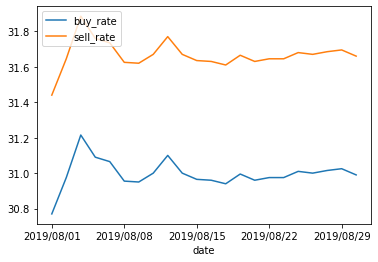


港幣(HKD)



<Figure size 720x576 with 0 Axes>

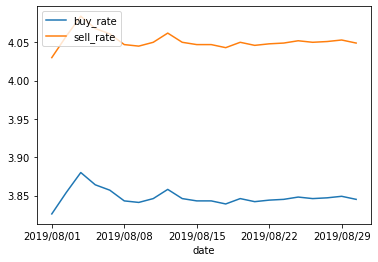


英鎊(GBP)



<Figure size 720x576 with 0 Axes>

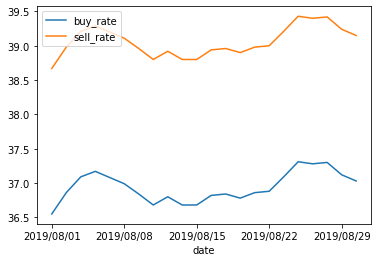


澳幣(AUD)



<Figure size 720x576 with 0 Axes>

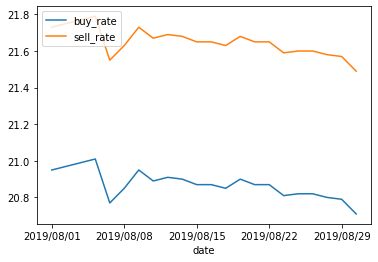


加拿大幣(CAD)



<Figure size 720x576 with 0 Axes>

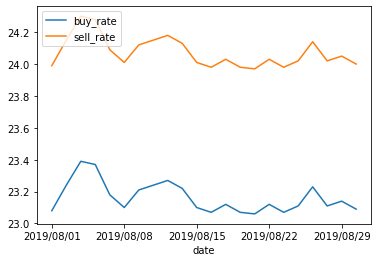


新加坡幣(SGD)



<Figure size 720x576 with 0 Axes>

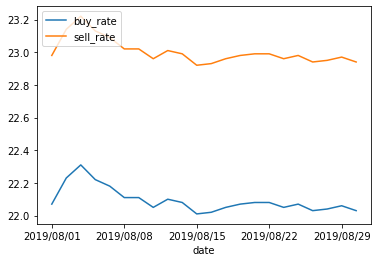


瑞士法郎(CHF)



<Figure size 720x576 with 0 Axes>

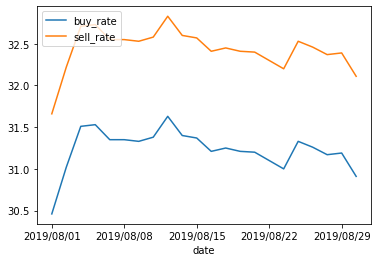


日圓(JPY)



<Figure size 720x576 with 0 Axes>

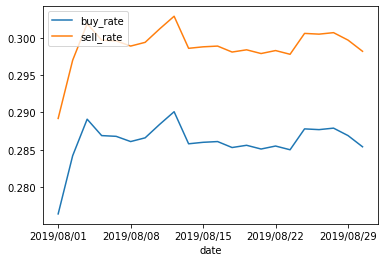


南非幣(ZAR)



<Figure size 720x576 with 0 Axes>

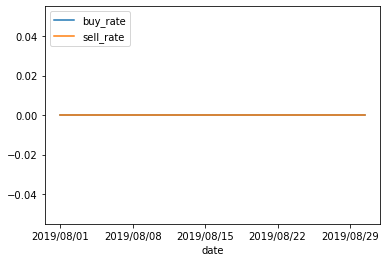


瑞典幣(SEK)



<Figure size 720x576 with 0 Axes>

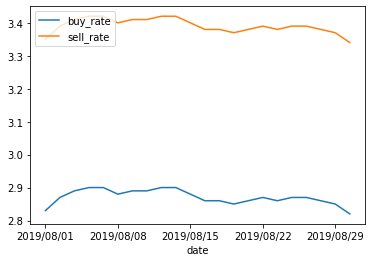


紐元(NZD)



<Figure size 720x576 with 0 Axes>

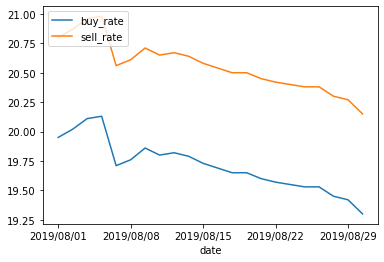


泰幣(THB)



<Figure size 720x576 with 0 Axes>

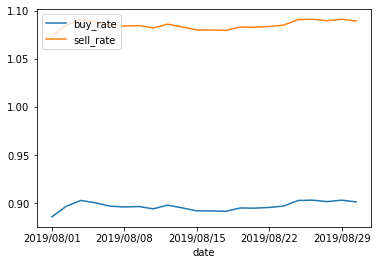


菲國比索(PHP)



<Figure size 720x576 with 0 Axes>

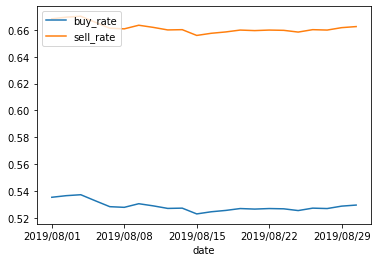


印尼幣(IDR)



<Figure size 720x576 with 0 Axes>

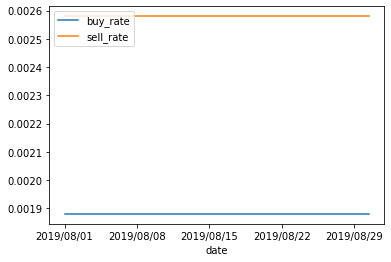


歐元(EUR)



<Figure size 720x576 with 0 Axes>

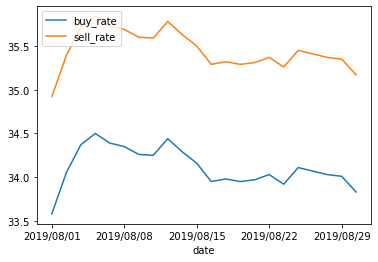


韓元(KRW)



<Figure size 720x576 with 0 Axes>

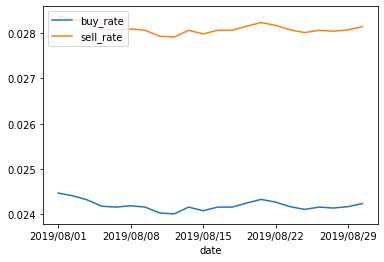


越南盾(VND)



<Figure size 720x576 with 0 Axes>

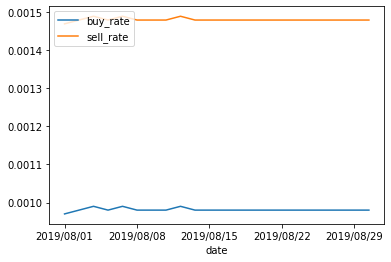


馬來幣(MYR)



<Figure size 720x576 with 0 Axes>

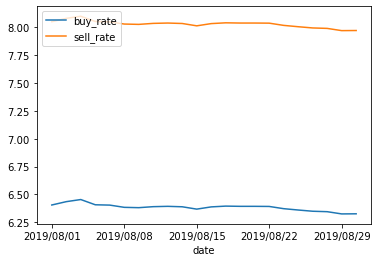


人民幣(CNY)



<Figure size 720x576 with 0 Axes>

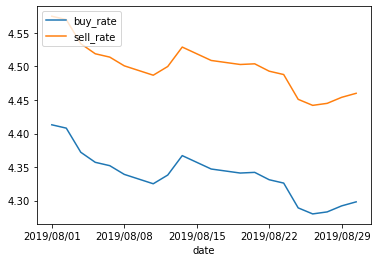

In [59]:
for r in rate_table:
    print(r.find(name='div', attrs={'class': 'visible-phone print_hide'}).text.replace(' ', ''))
    history_rate_link = 'https://rate.bot.com.tw' + r.find(name='td', attrs={'data-table': '歷史匯率'}).a['href']
    get_rate_history_chart(history_rate_link)